# SNN_1

This code builds on SNN_0 and takes real input from an image.  Initially this will be images from the MNIST dataset, a number picked at random (eventually!) to understand the propogration of spikes across layers in an SNN.

It aims to demonstrate/prove the following:

* A more complex input can be processed (rather than a flat network of circa 100 neurons in SNN_0)
* A higher stimulus will propogate quicker across the network (more spikes are generated, so they will have a bigger impact on neurons in higher layers)


## Running the simulation

The following code defines a set of LIF neurons and applies a stimulus to them. It then propogates the spikes to a neuron in a 2nd layer, graphing the results.

Note that some of the code from SNN_0 (such as the class LIFNeuron) has been lifted into seperate Python packages to improve readability and re-use across notebooks.

### Set up the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from neurons import LIFNeuron as LIF
from utils import graph_results as graph
from mnist import MNIST 
%matplotlib inline

###  Set up some parameters for the simulation

* Assume a consistent/single stimulus value for now that is applied for the duration of the simulation.
* Define the architecture of the SNN (layers, neurons per layer)

In [2]:
T         = 50    # total time to sumulate (msec)
dt        = 0.0125 # Simulation timestep
time      = int(T / dt)

debug=False

### Get an MNIST image

Start by getting an image from the MNIST dataset and render it

In [3]:
mndata = MNIST('./mnist')
images, labels = mndata.load_training()

def get_next_image(index=0):
    return images[index]
    
image = get_next_image(index=0)
print(mndata.display(image))


............................
............................
............................
............................
............................
.....................@@.....
.............@@@@@@.@@......
........@@@@@@@@@@..........
........@@@@@@..@@..........
...........@@@..............
............@...............
............@...............
.............@..............
.............@@.............
..............@@@...........
................@@..........
.................@@.........
.................@@@........
.................@@@........
..............@@@@@.........
............@@@@@@..........
..........@@@@@.............
........@@@@@...............
......@@@@@@................
.....@@@@...................
............................
............................
............................


Now convert to a Numpy array, normalise (into 0<=image<=1) for easier processing

In [4]:
image=np.asarray(image).reshape((28,28))
image_norm = (image * 255.0/image.max()) / 255.
print(image_norm)
print(image.shape)

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.        

Create a set of kernels for the image (assume a basic convolution will happen later)

In [5]:
stride = (4,2)   # TODO: This will be 4 on-centre neurons, 2 surround (off-centre) neurons
stride_size = stride[0] + stride[1]
len_x, len_y = image.shape
x_max = int(len_x/stride[0])
y_max = int(len_y/stride[0])
print ('Convolution Dimensions: x={} / y={}'.format(x_max, y_max))  #', starting at x={}, y={}'.format(x_max, y_max, x_count, y_count))

Convolution Dimensions: x=7 / y=7


Render the image in each of it's retinal 'zones'

This will be the basis of what each retinal unit views as we progress.

Not that the pixels that will have the strongest stimuli are white (as they are closer to 1), areas of least stimuli are black (value close to 0).

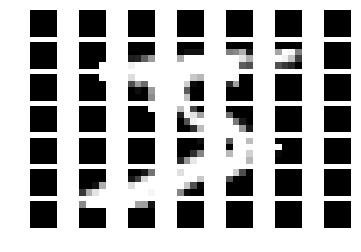

In [6]:
fig = plt.figure() #int(x_max+1) * int(y_max+1))
x_count, y_count = 1, 1

for y in range (0, len_y, stride[0]):
    x_count = 1
    for x in range(0, len_x, stride[0]):
        x_end = x + stride[0]
        y_end = y + stride[0]
        kernel = image_norm[y:y_end, x:x_end]
        #orientation = s1(kernel)
        a = fig.add_subplot(y_max, x_max, (y_count-1)*x_max+x_count)
        a.axis('off')
        plt.imshow(kernel, cmap="gray")    
        x_count += 1
    y_count += 1
plt.show()    

### Create a retinal unit

This is working with a single part of the image (currently starting at x=5 and y=5) to simulate the wider solution.  It will create a matrix of neuron classes (stride_x = 6, stride_y = 6) currently 36 neurons in total.

In [7]:
start_x = 5
start_y = 5

In [8]:
neurons=[]
for y in range(start_y, start_y + stride_size, 1):
    neuron_row=[]
    for x in range(start_x, start_x + stride_size, 1):
        neuron_row.append(LIF.LIFNeuron(debug=debug))
    neurons.append(neuron_row)

Input at 5/5 for neuron 0/0 = [ 0.  0.  0. ...,  0.  0.  0.]


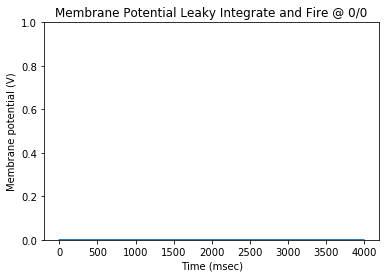

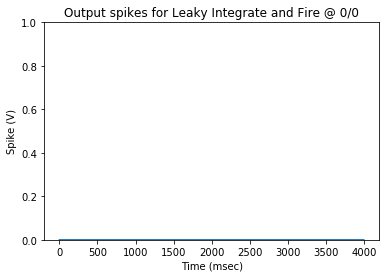

Input at 6/5 for neuron 1/0 = [ 0.  0.  0. ...,  0.  0.  0.]


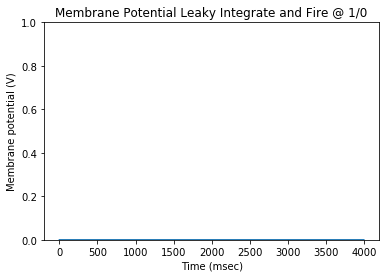

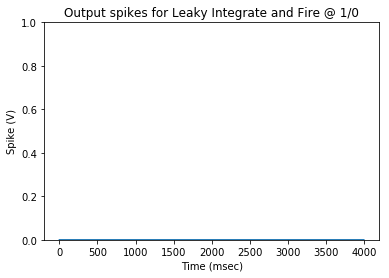

Input at 7/5 for neuron 2/0 = [ 0.  0.  0. ...,  0.  0.  0.]


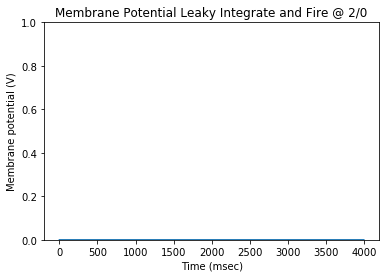

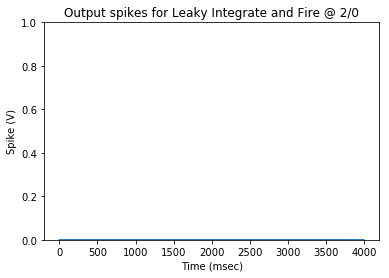

Input at 8/5 for neuron 3/0 = [ 0.  0.  0. ...,  0.  0.  0.]


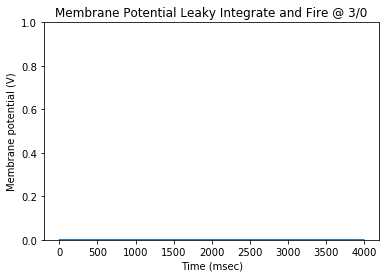

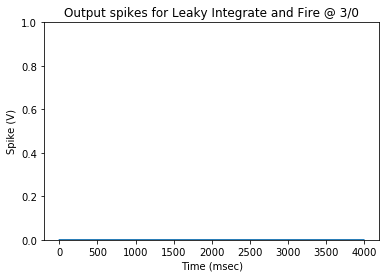

Input at 9/5 for neuron 4/0 = [ 0.  0.  0. ...,  0.  0.  0.]


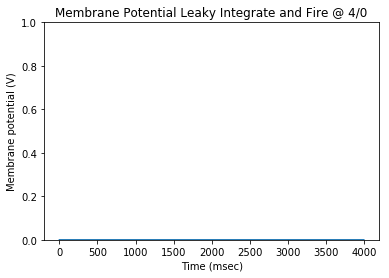

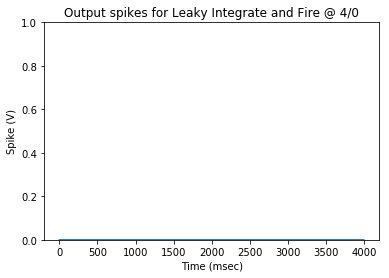

Input at 10/5 for neuron 5/0 = [ 0.  0.  0. ...,  0.  0.  0.]


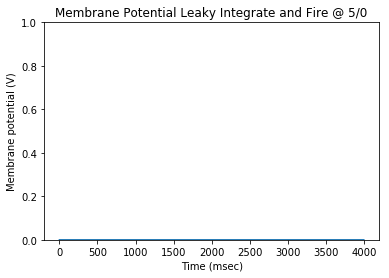

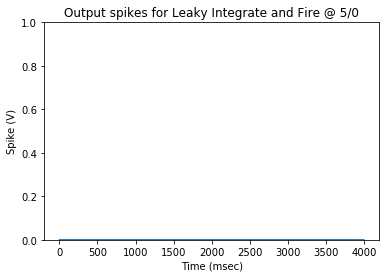

Input at 5/6 for neuron 0/1 = [ 0.  0.  0. ...,  0.  0.  0.]


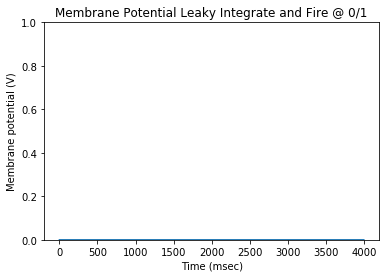

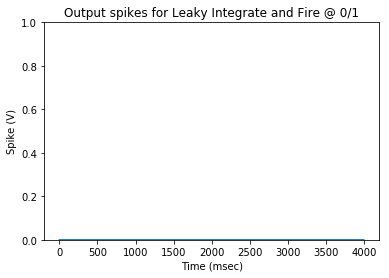

Input at 6/6 for neuron 1/1 = [ 0.  0.  0. ...,  0.  0.  0.]


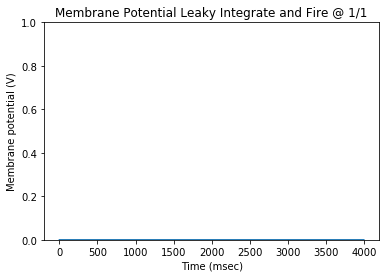

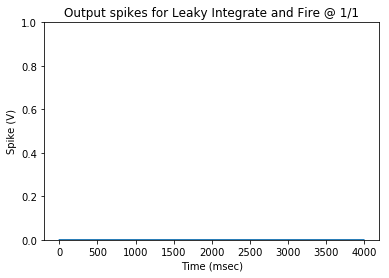

Input at 7/6 for neuron 2/1 = [ 0.  0.  0. ...,  0.  0.  0.]


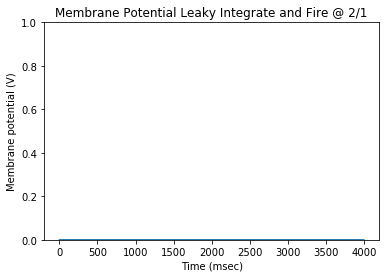

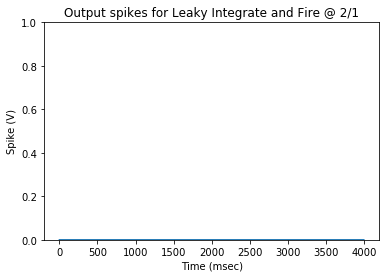

Input at 8/6 for neuron 3/1 = [ 0.11764706  0.11764706  0.11764706 ...,  0.11764706  0.11764706
  0.11764706]


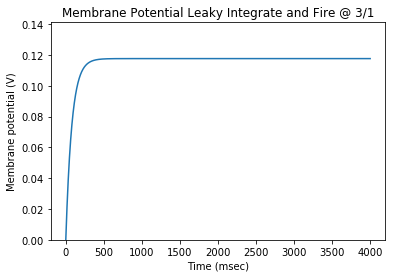

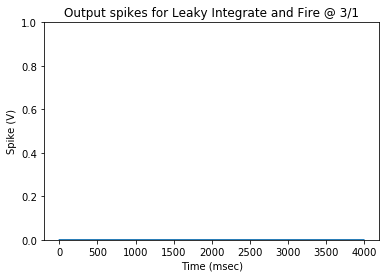

Input at 9/6 for neuron 4/1 = [ 0.14117647  0.14117647  0.14117647 ...,  0.14117647  0.14117647
  0.14117647]


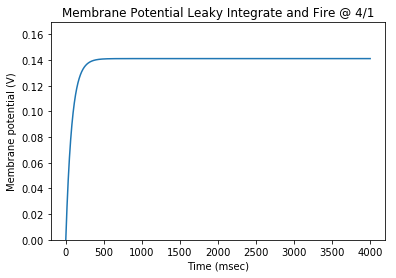

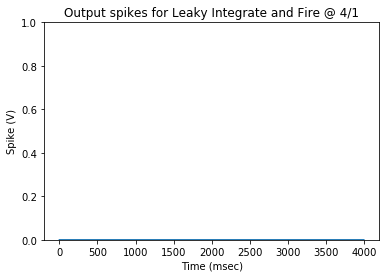

Input at 10/6 for neuron 5/1 = [ 0.36862745  0.36862745  0.36862745 ...,  0.36862745  0.36862745
  0.36862745]


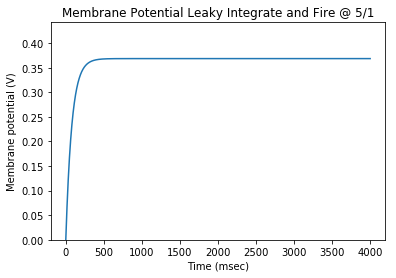

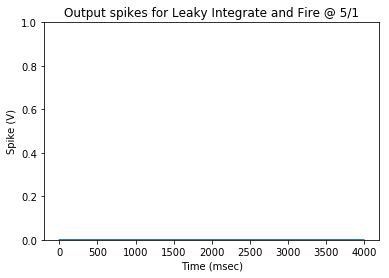

Input at 5/7 for neuron 0/2 = [ 0.  0.  0. ...,  0.  0.  0.]


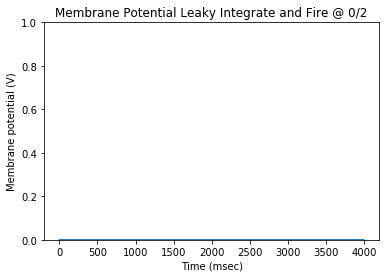

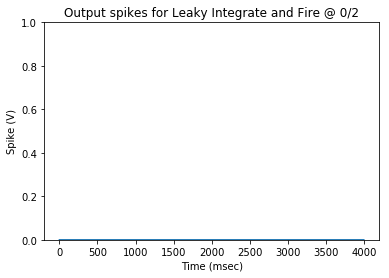

Input at 6/7 for neuron 1/2 = [ 0.  0.  0. ...,  0.  0.  0.]


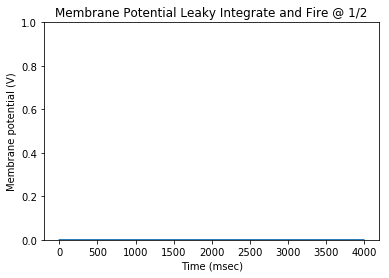

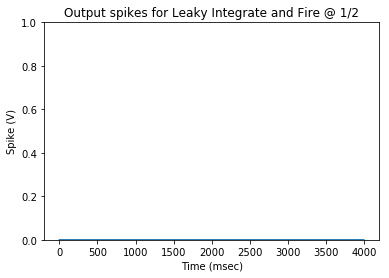

Input at 7/7 for neuron 2/2 = [ 0.19215686  0.19215686  0.19215686 ...,  0.19215686  0.19215686
  0.19215686]


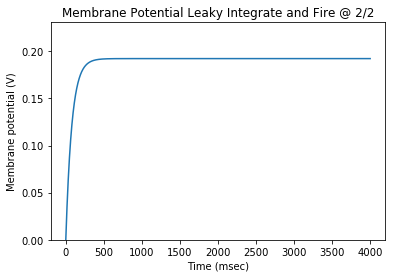

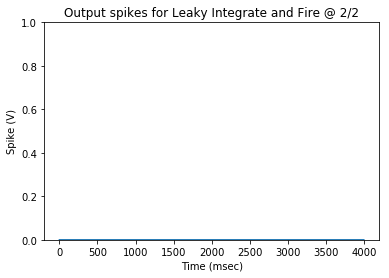

Input at 8/7 for neuron 3/2 = [ 0.93333333  0.93333333  0.93333333 ...,  0.93333333  0.93333333
  0.93333333]


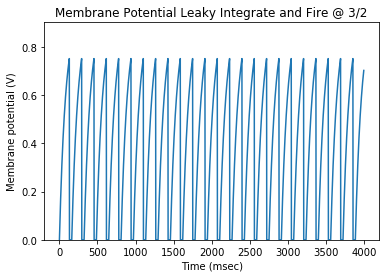

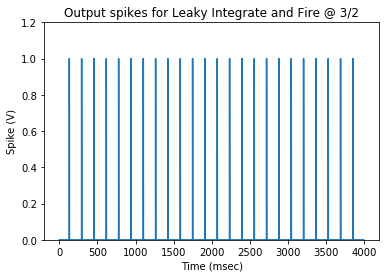

Input at 9/7 for neuron 4/2 = [ 0.99215686  0.99215686  0.99215686 ...,  0.99215686  0.99215686
  0.99215686]


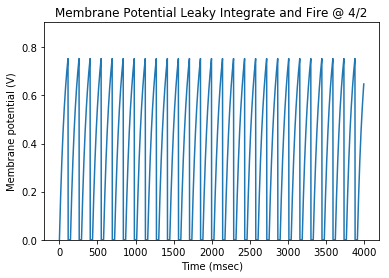

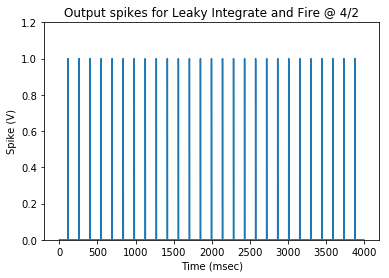

Input at 10/7 for neuron 5/2 = [ 0.99215686  0.99215686  0.99215686 ...,  0.99215686  0.99215686
  0.99215686]


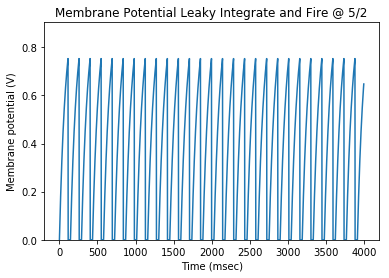

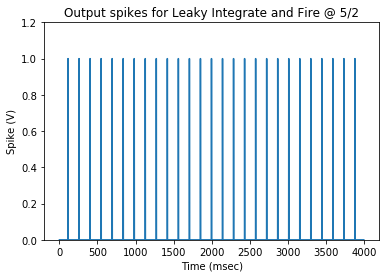

Input at 5/8 for neuron 0/3 = [ 0.  0.  0. ...,  0.  0.  0.]


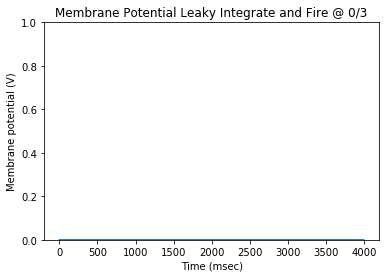

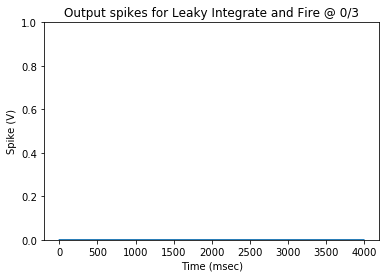

Input at 6/8 for neuron 1/3 = [ 0.  0.  0. ...,  0.  0.  0.]


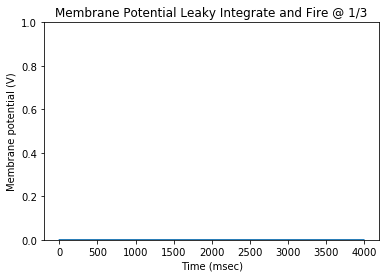

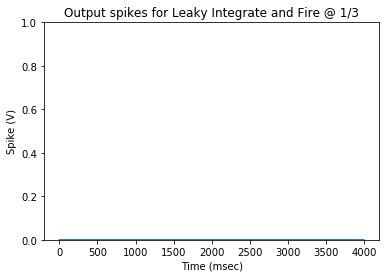

Input at 7/8 for neuron 2/3 = [ 0.07058824  0.07058824  0.07058824 ...,  0.07058824  0.07058824
  0.07058824]


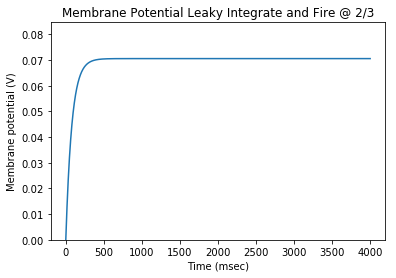

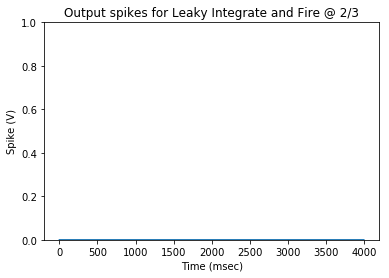

Input at 8/8 for neuron 3/3 = [ 0.85882353  0.85882353  0.85882353 ...,  0.85882353  0.85882353
  0.85882353]


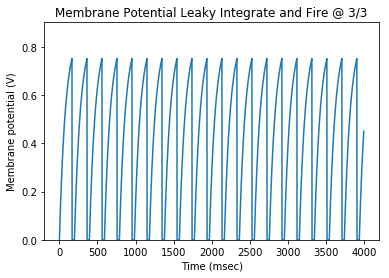

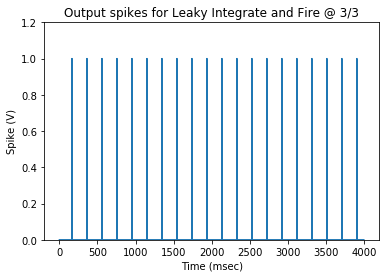

Input at 9/8 for neuron 4/3 = [ 0.99215686  0.99215686  0.99215686 ...,  0.99215686  0.99215686
  0.99215686]


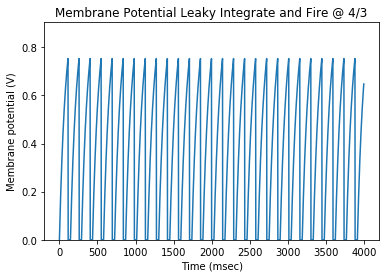

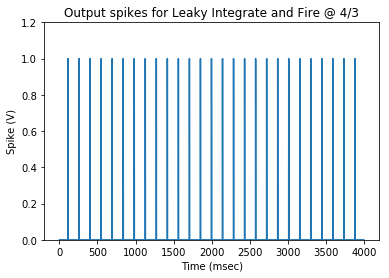

Input at 10/8 for neuron 5/3 = [ 0.99215686  0.99215686  0.99215686 ...,  0.99215686  0.99215686
  0.99215686]


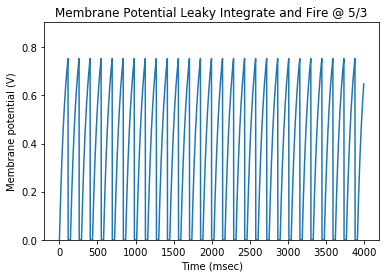

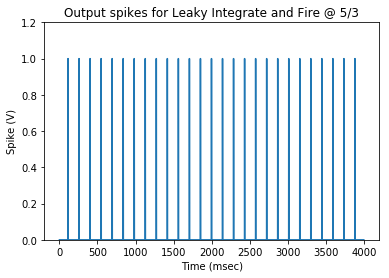

Input at 5/9 for neuron 0/4 = [ 0.  0.  0. ...,  0.  0.  0.]


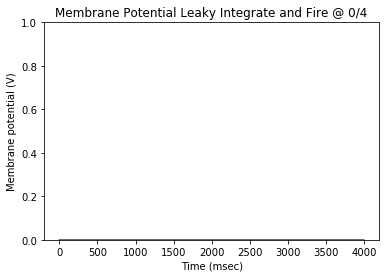

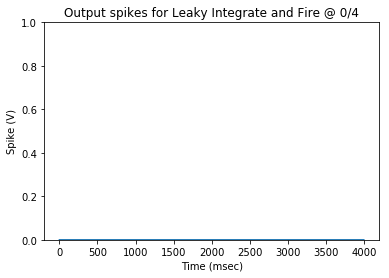

Input at 6/9 for neuron 1/4 = [ 0.  0.  0. ...,  0.  0.  0.]


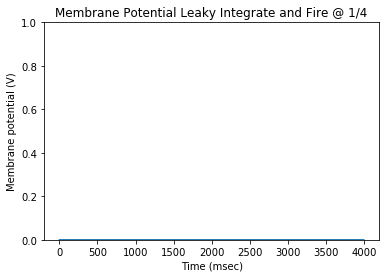

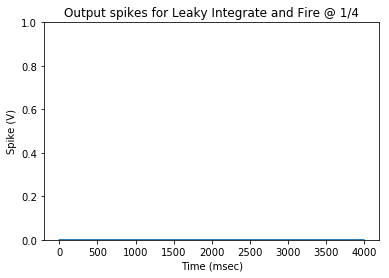

Input at 7/9 for neuron 2/4 = [ 0.  0.  0. ...,  0.  0.  0.]


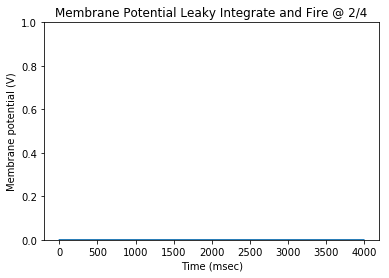

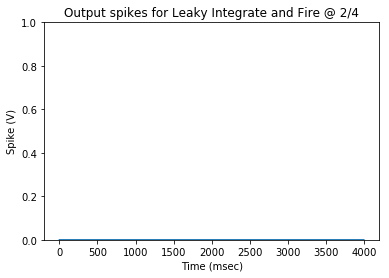

Input at 8/9 for neuron 3/4 = [ 0.31372549  0.31372549  0.31372549 ...,  0.31372549  0.31372549
  0.31372549]


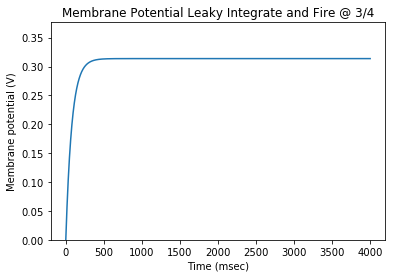

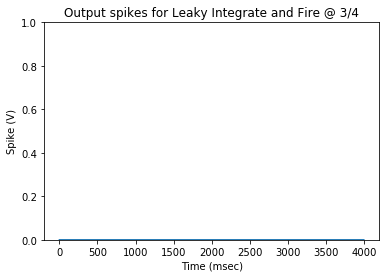

Input at 9/9 for neuron 4/4 = [ 0.61176471  0.61176471  0.61176471 ...,  0.61176471  0.61176471
  0.61176471]


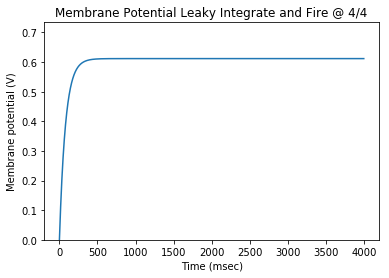

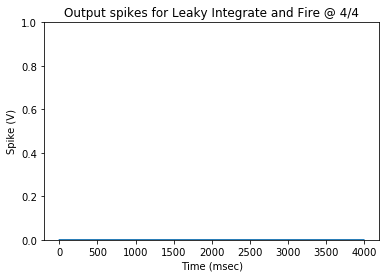

Input at 10/9 for neuron 5/4 = [ 0.41960784  0.41960784  0.41960784 ...,  0.41960784  0.41960784
  0.41960784]


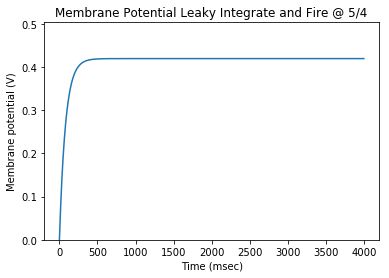

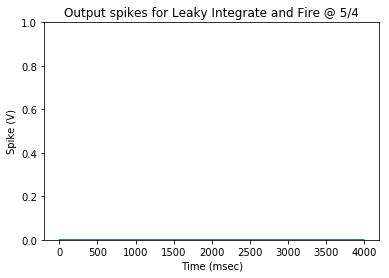

Input at 5/10 for neuron 0/5 = [ 0.  0.  0. ...,  0.  0.  0.]


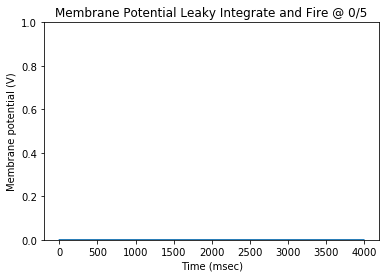

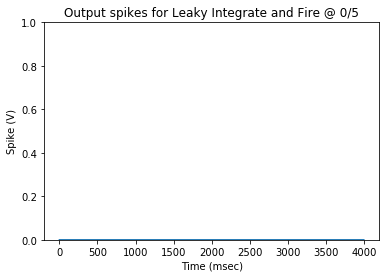

Input at 6/10 for neuron 1/5 = [ 0.  0.  0. ...,  0.  0.  0.]


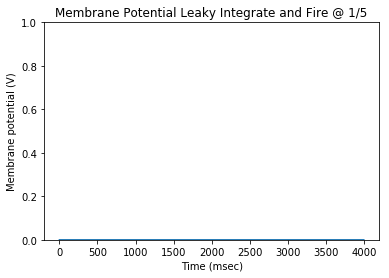

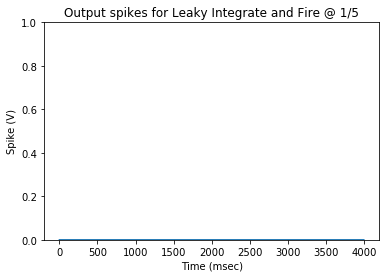

Input at 7/10 for neuron 2/5 = [ 0.  0.  0. ...,  0.  0.  0.]


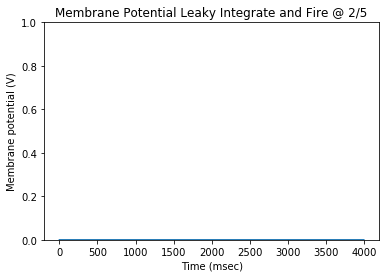

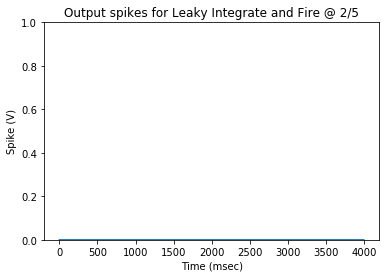

Input at 8/10 for neuron 3/5 = [ 0.  0.  0. ...,  0.  0.  0.]


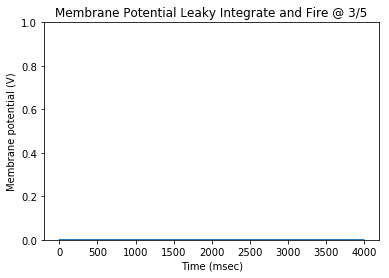

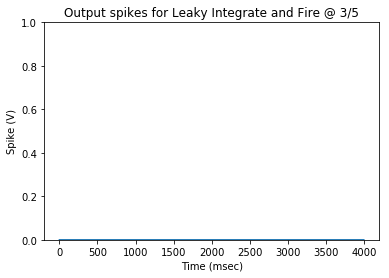

Input at 9/10 for neuron 4/5 = [ 0.05490196  0.05490196  0.05490196 ...,  0.05490196  0.05490196
  0.05490196]


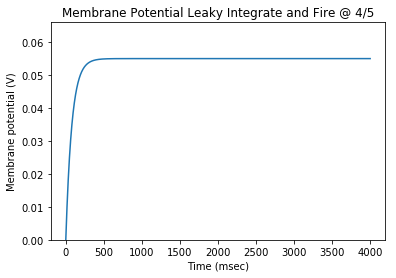

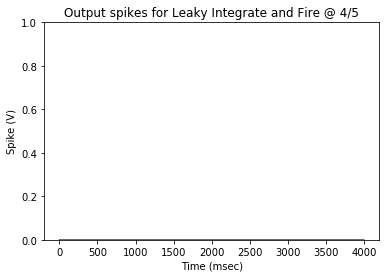

Input at 10/10 for neuron 5/5 = [ 0.00392157  0.00392157  0.00392157 ...,  0.00392157  0.00392157
  0.00392157]


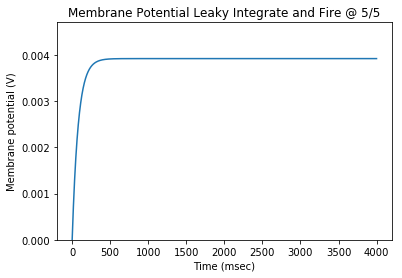

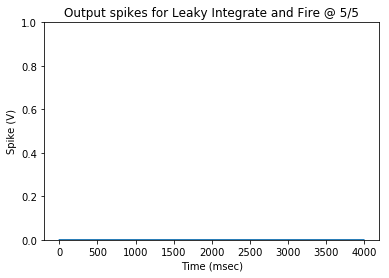

In [9]:
for y in range(start_y, start_y + stride_size, 1):
    for x in range(start_x, start_x + stride_size, 1):
        stimulus = np.full((time), image_norm[y,x])
        neuron_x = x-start_x
        neuron_y = y-start_y
        print ('Input at {}/{} for neuron {}/{} = {}'.format(x, y, neuron_x,neuron_y,stimulus))
        neurons[neuron_x][neuron_y].spike_generator(stimulus)
        graph.plot_membrane_potential(neurons[neuron_x][neuron_y].time, neurons[neuron_x][neuron_y].Vm, 'Membrane Potential {}'.format(neurons[neuron_x][neuron_y].type), neuron_id = "{}/{}".format(neuron_x, neuron_y))
        graph.plot_spikes(neurons[neuron_x][neuron_y].time, neurons[neuron_x][neuron_y].spikes, 'Output spikes for {}'.format(neurons[neuron_x][neuron_y].type), neuron_id = "{}/{}".format(neuron_x, neuron_y))

### Sum spikes into a neuron in the next layer

Assume a single neuron in the next layer takes input from this kernel

In [20]:
neuron2 = LIF.LIFNeuron(debug=debug)
stimulus_layer2 = np.zeros(time)
for y in range(start_y, start_y + stride_size, 1):
    for x in range(start_x, start_x + stride_size, 1):
        neuron_x = x-start_x
        neuron_y = y-start_y
        stimulus_layer2 += neurons[neuron_x][neuron_y].spikes[0:time]


In [21]:
print (stimulus_layer2[0:400])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

Input at 10/10 for neuron L=2/i=0 = [ 0.  0.  0. ...,  0.  0.  0.]


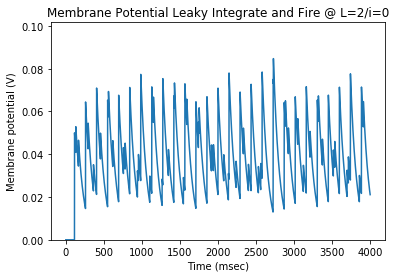

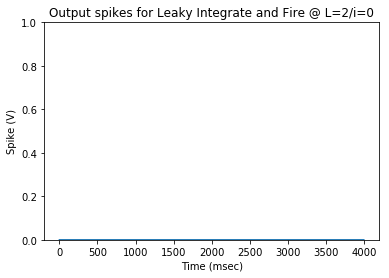

In [22]:
print ('Input at {}/{} for neuron {}/{} = {}'.format(x, y, "L=2","i=0",stimulus_layer2))
neuron2.spike_generator(stimulus_layer2)
graph.plot_membrane_potential(neuron2.time, neuron2.Vm, 'Membrane Potential {}'.format(neuron2.type), neuron_id = "L=2/i=0")
graph.plot_spikes(neuron2.time, neuron2.spikes, 'Output spikes for {}'.format(neuron2.type), neuron_id = "L=2/i=0")

# From SNN_0
Kept here for re-use as / if needed

Sum the spikes from the neurons in the 1st layer (layer=0)

In [175]:
layer = 0 
layer_spikes = np.zeros_like(neurons[layer][0].spikes)
for i in range(num_neurons):
    layer_spikes += neurons[layer][i].spikes    

Get a view of the spikes from the iterations 0 to 200

In [176]:
print (layer_spikes[0:200])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  2.  3.  0.  1.  0.  0.  3.  2.  2.  2.  3.  0.  1.
  1.  1.  5.  0.  2.  1.  2.  1.  0.  2.  2.  0.  0.  0.  0.  1.  1.  0.
  0.  1.  3.  1.  1.  1.  0.  2.  0.  1.  1.  0.  1.  3.  0.  0.  1.  1.
  2.  1.  1.  0.  1.  1.  1.  0.  1.  2.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  2.  1.  1.  1.  1.  1.  3.  0.  1.  3.  0.  0.  2.  1.  0.
  0.  0.]


Graph summed spike train from first layer. This is the input the neuron 0 on layer 1.


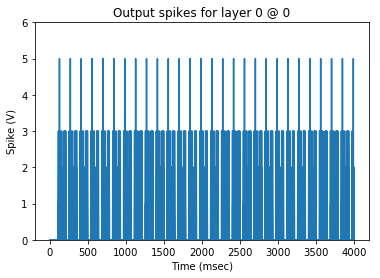

In [177]:
plot_spikes(neurons[0][0].time, layer_spikes, 'Output spikes for layer {}'.format(layer))

### Now simulate spikes propogated to a neuron on the 2nd layer

In [178]:
neurons[1][0]=Neuron(debug=False)             # Re-initialise this neuron in case of multiple runs
neurons[1][0].spike_generator(layer_spikes)   

In [182]:
start_time = 0
end_time = len(neurons[1][0].time)
print('Rendering neurons[1][0] over the time period {}:{}'.format(start_time,end_time))

Rendering neurons[1][0] over the time period 0:4002


### Graph the results

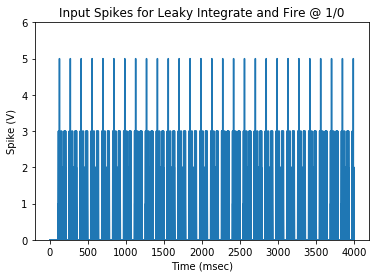

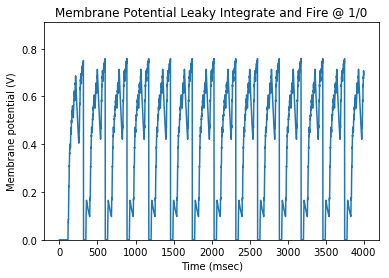

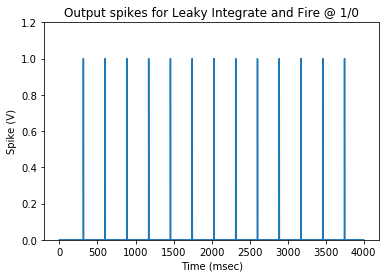

In [187]:
plot_spikes(neurons[0][0].time[start_time:end_time], layer_spikes[start_time:end_time], 
            'Input Spikes for {}'.format(neurons[1][0].type), neuron_id = "1/0")
plot_membrane_potential(neurons[1][0].time[start_time:end_time], neurons[1][0].Vm[start_time:end_time], 
            'Membrane Potential {}'.format(neurons[1][0].type), neuron_id = "1/0")
plot_spikes(neurons[1][0].time[start_time:end_time], neurons[1][0].spikes[start_time:end_time], 
            'Output spikes for {}'.format(neurons[1][0].type), neuron_id = "1/0")

## Findings

The following findings were made:
    
* The model works and it is possible to see spike trains propogate between different layers in an SNN
* Only a simple model using feedforward has been applied here
* Different spike trains are evidenced depending on the offset of the applied stimulus
* There is no real view of biological plausability here, and this code base is unlikely to offer anything in terms of a real use-case
* It has been a useful experience to understand the mechanics of a basic spiking network, and to witness it in action


## Next steps

* Explore other neuron types (Hodkins-Huxley neurons for example)
* Explore how to develop a more complex layered model with feedforward, then with feedback too
* Explore the impact of inhibitory neurons (excitory neurons are modelled above)
* Explore how to integrate this with real stimuli (for example MNIST data)
* Explore how to integrate learning into this multi-layered model

